In [ ]:
!pip install ipyleaflet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00


In [ ]:
!pip install odc-stac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.0 MB/s eta 0:00:00


In [ ]:
!pip install planetary-computer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install Rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m rich

                                 Rich features                                  
                                                                                
    Colors    ✓ 4-bit color                 ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ 
              ✓ 8-bit color                 ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ 
              ✓ Truecolor (16.7 million)    ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ 
              ✓ Dumb terminals              ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ 
              ✓ Automatic color conversion  ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ 
                                                                                
    Styles    All ansi styles: bold, dim, italic, underline, strikethrough,     
              reverse, and even blink.                                          
                                                                                
     Text     Word wrap text. Justify left, center, right or full.              
                            

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Loading the dependencies

In [ ]:
import odc
from odc import stac
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
# import odc-stac
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('8037994b42c1450e9a4daca46c196464')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [ ]:
crop_presence_data = pd.read_csv("/content/drive/MyDrive/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [ ]:
def get_sentinel_data(latlong, time_slice, assets):
  '''
  Returns VV and VH values for a given latitude and longitude 
  Attributes:
  latlong - A tuple with 2 elements - latitude and longitude
  time_slice - Timeframe for which the VV and VH values have to be extracted
  assets - A list of bands to be extracted
  '''
  latlong = latlong.replace('(','').replace(')','').replace(' ','').split(',')
  for i in range(2):
    latlong[i] = float(latlong[i])

  time_of_interest = time_slice
  box_size_deg = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region
  min_lon = latlong[1] - box_size_deg / 2
  min_lat = latlong[0] - box_size_deg / 2
  max_lon = latlong[1] + box_size_deg / 2
  max_lat = latlong[0] + box_size_deg / 2
  bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)

  catalog = pystac_client.Client.open(
      "https://planetarycomputer.microsoft.com/api/stac/v1"
  )
  search = catalog.search(
      collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
  )
  items = list(search.get_all_items())
  bands_of_interest = assets
  resolution = 10  # meters per pixel 
  scale = resolution / 111320.0
  data = stac_load([items[0]], bands = bands_of_interest, patch_url=pc.sign,crs="EPSG:4326",resolution=scale,bbox=bbox_of_interest)
  vh = data["vh"].astype("float").values.tolist()[0][0]
  vv = data["vv"].astype("float").values.tolist()[0][0]

  mean = data.mean(dim=['latitude','longitude']).compute()
  dop = (mean.vv / (mean.vv + mean.vh))
  m = 1 - dop
  rvi = (np.sqrt(dop))*((4*mean.vh)/(mean.vv + mean.vh))
  return vh[0],vv[0]

In [ ]:
time_slice = '2020-03-20/2021-03-21'
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 600/600 [06:54<00:00,  1.45it/s]


In [ ]:
vh_vv_data.head()

,vh,vv
0,0.028296,0.112560
1,0.051894,0.048721
2,0.033304,0.081855
3,0.010928,0.024132
4,0.012968,0.015349


In [ ]:
def combine_two_datasets(dataset1,dataset2):
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

,Latitude and Longitude,Class of Land,vh,vv
0,"(10.323727047081501, 105.2516346045924)",Rice,0.028296,0.112560
1,"(10.322364360592521, 105.27843410554115)",Rice,0.051894,0.048721
2,"(10.321455902933202, 105.25254306225168)",Rice,0.033304,0.081855
3,"(10.324181275911162, 105.25118037576274)",Rice,0.010928,0.024132
4,"(10.324635504740822, 105.27389181724476)",Rice,0.012968,0.015349


# MODEL

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
crop_data = crop_data[['vh','vv','Class of Land']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

# poly = PolynomialFeatures(degree = 3, interaction_only=True)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)

sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# TRAINING

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=1, random_state=0)
model.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=150, random_state=0)

In [ ]:
insample_predictions = model.predict(X_train)
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 81.67%
              precision    recall  f1-score   support

    Non Rice       0.84      0.80      0.82       221
        Rice       0.79      0.83      0.81       199

    accuracy                           0.82       420
   macro avg       0.82      0.82      0.82       420
weighted avg       0.82      0.82      0.82       420



In [ ]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    
    '''Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.'''
   
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

In [ ]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Gradient Boosting Method In-Sample Results",['Rice', 'Non Rice'])

# TESTING

In [ ]:
outsample_predictions = model.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))
#print(outsample_predictions)

Accuracy 88.89%
              precision    recall  f1-score   support

    Non Rice       0.88      0.90      0.89        90
        Rice       0.90      0.88      0.89        90

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180



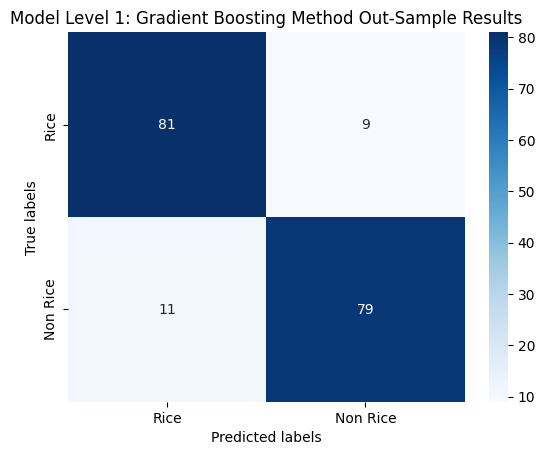

In [ ]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Gradient Boosting Method Out-Sample Results",['Rice', 'Non Rice'])

# KNN - TRAINING

In [ ]:
'''from sklearn.neighbors import KNeighborsClassifier'''

In [ ]:
'''pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier())
])
k = 25  
pipeline.set_params(knn__n_neighbors=k)
pipeline.fit(X_train, y_train)
insample_prediction2 = pipeline.predict(X_train)
print("Accuracy {0:.2f}%".format(100*accuracy_score(insample_prediction2, y_train)))
print(classification_report(insample_prediction2,y_train))'''

# KNN - TESTING

In [ ]:
'''outsample_prediction2 = pipeline.predict(X_test)
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_prediction2, y_test)))
print(classification_report(outsample_prediction2,y_test))'''

# SELECTING DIFFERENT MODELS

In [ ]:
from sklearn.utils import all_estimators
def getClassifiers(classifier):
    classifierModels = []
    for name, ClassifierClass in all_estimators(type_filter=classifier):
        try:
            classifier = ClassifierClass()
            classifierModels.append((name, classifier))
        except Exception as e:
            pass
    return classifierModels

classifierModels = getClassifiers('classifier')
print(len(classifierModels))
model1 = classifierModels[: 10]
model2 = classifierModels[10: 20]
model3 = classifierModels[20: 30]
model4 = classifierModels[30: 34]

34


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score

def evaluate(model, XTrain, yTrain, XTest, yTest):
    model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    accuracy = accuracy_score(yTest, yPred)
    # f1 = f1_score(yTest, yPred)
    print(f'Model Name = {type(model).__name__}, accuracy score = {accuracy}')
    print(classification_report(y_test, yPred))

In [ ]:
def tryModels(models):
    for model in models:
        try:
            print(f'Running {type(model[1]).__name__}')
            ans = evaluate(model[1], X_train, y_train, X_test, y_test)
            # print(classification_report(y_test, outsample_predictions))
            print(ans)
        except Exception as e:
            pass

In [ ]:
tryModels(model1)

Running AdaBoostClassifier
Model Name = AdaBoostClassifier, accuracy score = 0.8166666666666667
              precision    recall  f1-score   support

    Non Rice       0.80      0.84      0.82        90
        Rice       0.84      0.79      0.81        90

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180

None
Running BaggingClassifier
Model Name = BaggingClassifier, accuracy score = 0.8555555555555555
              precision    recall  f1-score   support

    Non Rice       0.83      0.89      0.86        90
        Rice       0.88      0.82      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180

None
Running BernoulliNB
Model Name = BernoulliNB, accuracy score = 0.6722222222222223
              precision    recall  f1-score   support

    Non R

In [ ]:
tryModels(model2)

Running GaussianNB
Model Name = GaussianNB, accuracy score = 0.5
              precision    recall  f1-score   support

    Non Rice       0.00      0.00      0.00        90
        Rice       0.50      1.00      0.67        90

    accuracy                           0.50       180
   macro avg       0.25      0.50      0.33       180
weighted avg       0.25      0.50      0.33       180

None
Running GaussianProcessClassifier
Model Name = GaussianProcessClassifier, accuracy score = 0.9
              precision    recall  f1-score   support

    Non Rice       0.91      0.89      0.90        90
        Rice       0.89      0.91      0.90        90

    accuracy                           0.90       180
   macro avg       0.90      0.90      0.90       180
weighted avg       0.90      0.90      0.90       180

None
Running GradientBoostingClassifier
Model Name = GradientBoostingClassifier, accuracy score = 0.85
              precision    recall  f1-score   support

    Non Rice       0.84

In [ ]:
tryModels(model3)

Running LogisticRegressionCV
Model Name = LogisticRegressionCV, accuracy score = 0.6111111111111112
              precision    recall  f1-score   support

    Non Rice       0.65      0.49      0.56        90
        Rice       0.59      0.73      0.65        90

    accuracy                           0.61       180
   macro avg       0.62      0.61      0.61       180
weighted avg       0.62      0.61      0.61       180

None
Running MLPClassifier
Model Name = MLPClassifier, accuracy score = 0.7888888888888889
              precision    recall  f1-score   support

    Non Rice       0.87      0.68      0.76        90
        Rice       0.74      0.90      0.81        90

    accuracy                           0.79       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.79      0.79       180

None
Running MultinomialNB
Running NearestCentroid
Model Name = NearestCentroid, accuracy score = 0.5
              precision    recall  f1-score   support

In [ ]:
tryModels(model4)

Running RidgeClassifier
Model Name = RidgeClassifier, accuracy score = 0.6111111111111112
              precision    recall  f1-score   support

    Non Rice       0.65      0.49      0.56        90
        Rice       0.59      0.73      0.65        90

    accuracy                           0.61       180
   macro avg       0.62      0.61      0.61       180
weighted avg       0.62      0.61      0.61       180

None
Running RidgeClassifierCV
Model Name = RidgeClassifierCV, accuracy score = 0.6111111111111112
              precision    recall  f1-score   support

    Non Rice       0.65      0.49      0.56        90
        Rice       0.59      0.73      0.65        90

    accuracy                           0.61       180
   macro avg       0.62      0.61      0.61       180
weighted avg       0.62      0.61      0.61       180

None
Running SGDClassifier
Model Name = SGDClassifier, accuracy score = 0.3277777777777778
              precision    recall  f1-score   support

    Non Ric

In [ ]:
from sklearn.semi_supervised import LabelPropagation
model0 = LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000)
model0.fit(XTrain,yTrain)

LabelPropagation(kernel='knn')

In [ ]:
insample_predictions0 = model0.predict(XTest)
print("Outsample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions0,yTest)))
print(classification_report(insample_predictions0,yTest))

Outsample Accuracy 88.33%
              precision    recall  f1-score   support

    Non Rice       0.92      0.86      0.89        97
        Rice       0.84      0.92      0.88        83

    accuracy                           0.88       180
   macro avg       0.88      0.89      0.88       180
weighted avg       0.89      0.88      0.88       180



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=150, max_depth=1, random_state=0)
rf_model.fit(XTrain, yTrain)
predicted_labels2 = rf_model.predict(XTest)
print("Outsample Accuracy {0:.2f}%".format(100*accuracy_score(predicted_labels2,yTest)))
print(classification_report(predicted_labels2,yTest))

Outsample Accuracy 82.22%
              precision    recall  f1-score   support

    Non Rice       0.74      0.88      0.81        76
        Rice       0.90      0.78      0.84       104

    accuracy                           0.82       180
   macro avg       0.82      0.83      0.82       180
weighted avg       0.83      0.82      0.82       180



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(XTrain, yTrain)
predicted_labels3 = knn_model.predict(XTest)
print("Outsample Accuracy {0:.2f}%".format(100*accuracy_score(predicted_labels3,yTest)))
print(classification_report(predicted_labels3,yTest))

Outsample Accuracy 88.33%
              precision    recall  f1-score   support

    Non Rice       0.92      0.86      0.89        97
        Rice       0.84      0.92      0.88        83

    accuracy                           0.88       180
   macro avg       0.88      0.89      0.88       180
weighted avg       0.89      0.88      0.88       180

